# LQR finite and infite horizon

We have the following LTI dynamics
$$x_{t+1} = A\, x_t + B \,u_t  = \left[\begin{smallmatrix} 2 & 0.3 \\ 2 & 3 \end{smallmatrix}\right] x_t + \left[\begin{smallmatrix} 1 & 0.2 \\ 0.5 & 1 \end{smallmatrix}\right] u_t.$$

Solve the following optimal control problem (OPC)

\begin{array}{ll} \mbox{minimize} & \sum_{t=0}^{T-1} x_t^\top Q x_t +  \, u_t^\top R u_t + x_T^\top S x_T \\\mbox{subject to} & x_{t+1} = A\,x_t + B\,u_t\\ \end{array}

with $Q = \left[\begin{smallmatrix} 1 & 0 \\ 0 &  1\end{smallmatrix}\right]$ and $R = \left[\begin{smallmatrix} 1 & 0 \\ 0 & 1 \end{smallmatrix}\right]$.



Question 1:

Is the LTI system stable?

Answer 1:

No, it is unstable. The eigenvalues of the A matrix are: $\lambda_1$ = 3.422 and $\lambda_2=1.578$. You can easily check this by hand calculation or the follwing code below.


In [ ]:
import numpy as np

A = np.array([[2,0.3], [2,3]])
print(np.linalg.eigvals(A).round(3))


[1.578 3.422]


In [ ]:
# Generate data for control problem.

#%%
n_x, n_u = 2,2

T = 3

B = np.array([[1, 0.2], [0.5, 1]])
Q = np.array([[1,0], [0,1]])
R = np.array([[1,0], [0,1]])
S = 10*Q

**Finite horizon LQR feedback**

We simualte the closed-loop system for a finite horizon $T=3$ under the LQR control law.


In [ ]:
# Begin by computing and storing the optimal cost matrices
#
P_all =  [[] for t in range(T+1)]

#initialize P
P = S

for t in range(T+1):

    P_all[T-t] = P
    P = Q + A.T @ P @ A - A.T@ P @ B @ np.linalg.inv(R + B.T @ P @ B)@ B.T @ P @ A




In [ ]:
#%% Simulate the system

#Initial condition
x0 = np.array([100,150])
x =  x0

#Initialize array to store trajectory
x_traj = np.zeros([T+1,n_x])
x_traj[0,:] = x

Gamma_t = [[] for t in range(T)]

for t in range(T):

    # Compute optimal feedback gain
    Gamma_t[t] = -np.linalg.inv(R + B.T @ P_all[t+1] @ B)@ B.T @ P_all[t+1] @ A

    x = (A + B @ Gamma_t[t]) @ x
    x_traj[t+1,:] = x

print('x finite trajectory: ' + str(list(x_traj)))

x finite trajectory: [array([100., 150.]), array([-53.66150242,  74.6102798 ]), array([-43.13390568,  28.2629705 ]), array([-9.91227954,  5.03015236])]


**Infinite horizon LQR feedback: $T\to \infty$**

P = la.solve_discrete_are(A, B, Q, R)

Solves the discrete-time algebraic Riccati equation.



In [ ]:
# A second option:
import scipy.linalg as la

P_inf = la.solve_discrete_are(A, B, Q, R)


In [ ]:
## Second option to compute P_inf
#pip install control
import control as ct

P_inf, L, Gamma_inf = ct.dare(A, B, Q, R)


In [ ]:
#%% Simulate the system

#Initial condition
x0 = np.array([100,150])
x =  x0

#Initialize array to store trajectory
x_traj_inf = np.zeros([T+1,n_x])
x_traj_inf[0,:] = x

Gamma_inf = -np.linalg.inv(R + B.T @ P_inf.T @ B) @ B.T @ P_inf @ A

for t in range(T):

    x = (A + B @ Gamma_inf) @ x
    x_traj_inf[t+1,:] = x

print('x infinite trajectory: ' + str(list(x_traj_inf)))

x infinite trajectory: [array([100., 150.]), array([-54.85154044,  78.08119122]), array([-48.84785993,  36.19496759]), array([-27.09004879,  15.80356778])]


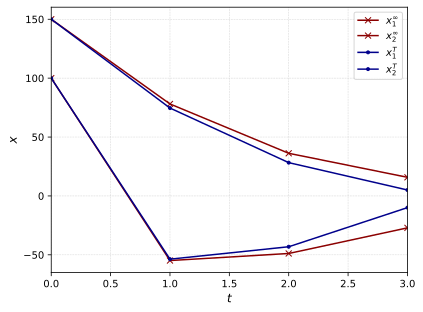

In [ ]:
#%% Plotting
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x_traj_inf, marker = 'x', color = 'darkred')
ax.plot(x_traj, marker = '.', color = 'darkblue')

ax.grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
ax.set_xlim([0,T])
ax.set_ylabel(r"$x$", fontsize=12)
ax.set_xlabel(r"$t$", fontsize=12)
ax.set_title('', fontsize=12)
ax.legend([r'$x_1^{\infty}$', r'$x_2^{\infty}$','$x_1^{T}$', '$x_2^{T}$' ]
              ,fontsize=10)


**Question 1:**

What happens for increasing horizon length as T$\to \infty$?

-->Plot the trajectories above for different horizon length and observe how the finite and infite horizon trajectories converge as you increase the horizon lentgh.

In [ ]:
#Print the matrices of P_inf and P_all for different horizon lengths to compare them

print(P_inf)

print(P_all[0])

[[5.10230823 3.18069562]
 [3.18069562 8.32019326]]
[[5.10300149 3.18888512]
 [3.18888512 8.41475967]]


**Question 2:**

Is the infinite horizon controller cost optimal even for the finite horizon problem?


-->Compute the total cost under the infinite and finite horizon control law

You should compare and show that:

$
J_{\text{finite}}^* = \sum_{0}^{T-1} \left(x_{t}^\top Q x_{t} + (\Gamma_{t} x_{t})^\top  R \, (\Gamma_{t} x_{t})\right)+ x_{T}^\top S\, x_{T} \leq \sum_{0}^{T-1} \left(x_{t, \infty}^\top Q x_{t, \infty} + (\Gamma_{\infty} x_{t, \infty})^\top  R \, (\Gamma_{\infty} x_{t, \infty}) \right) + x_{T, \infty}^\top S\, x_{T, \infty}
$

In [ ]:
#%% Compute Optimal Cost

J_inf = 0
J_T = 0

for t in range(T):

    J_inf += x_traj_inf[t,:].T @ Q @ x_traj_inf[t,:] + (Gamma_inf @ x_traj_inf[t,:]).T @ R @ (Gamma_inf @ x_traj_inf[t,:])

    J_T += x_traj[t,:].T @ Q @ x_traj[t,:] + (Gamma_t[t] @ x_traj[t,:]).T @ R @ (Gamma_t[t] @ x_traj[t,:])

J_inf += x_traj_inf[T,:].T @ S @ x_traj_inf[T,:]
J_T += x_traj[T,:].T @ S @ x_traj[T,:]

print('J_inf is: ' + str(J_inf))
print('J_T is: ' + str(J_T))

print('J_T is: ' + str(x_traj[0,:].T @ P_all[0] @ x_traj[0,:] ))

J_inf is: 340385.54344596947
J_T is: 336028.66093376226
J_T is: 336028.6609337613
